# Birka Fuel Oil calculation using Auto-ML

Fuel Oil flow calculation of the Birka-data, using different Machine Learning strategies.

In [ ]:
%pylab inline
import pandas as pd
import sklearn
import time
import numpy as np

# Load the database

t1 = time.time()
print('Loading database ...')
df = pd.read_hdf('database/all_data_comp.h5','table')
print('Time to load database:', time.time()-t1)


Populating the interactive namespace from numpy and matplotlib
Loading database ...


# Feature selection FO-prediction data

Choose features for the model and export these to a new DataFrame. We first need to check the quality of the data, and see if if we have any NaN. In the first set we are going to use the volumetric flow meter for each fuel line as a predictor for the training.

As it is two fuel lines we create two individual models. Main engine 1,3 and Auxiliary Engine 1,3 are connected to one fuel line. 2/4 vice versa to the other one.

Lets start by using as few predictors as possible to speed up the model.



In [2]:
# Features and target for Eng 1/3

labels_1_3 = ['AE1 FUEL RACK POSIT:1742:mm:Average:900',
                'AE3 FUEL RACK POSIT:3742:mm:Average:900',
                'AE1 ENG SPEED:1745:RPM:Average:900',
                'AE3 ENG SPEED:3745:RPM:Average:900',
                'ME1 FUEL RACK POSIT:10005:%:Average:900',
                'ME3 FUEL RACK POSIT:30005:%:Average:900',
                'ME1 ENGINE SPEED:1364:rpm:Average:900',
                'ME3 ENGINE SPEED:3364:rpm:Average:900',
                'FO BOOST 1 CONSUMPT:6165:m3/h:Average:900']

# Features and target for Eng 2/4

labels_2_4 = ['AE2 FUEL RACK POSIT:2742:mm:Average:900',
                'AE4 FUEL RACK POSIT:4742:mm:Average:900',
                'AE2 ENG SPEED:2745:RPM:Average:900',
                'AE4 ENG SPEED:4745:RPM:Average:900',
                'ME2 FUEL RACK POSIT:20005:%:Average:900',
                'ME4 FUEL RACK POSIT:40005:%:Average:900',
                'ME2 ENGINE SPEED:2364:rpm:Average:900',
                'ME4 ENGINE SPEED:4364:rpm:Average:900',
             'FO BOOST 2 CONSUMPT:6166:m3/h:Average:900']


# Drop Nan from the DataFrame.

df_1_3 = df[labels_1_3].dropna()
df_2_4 = df[labels_2_4].dropna()

# Filter data
Some of the data may contain values which are way off.

In [3]:
print('Features 1/3:')
print(df_1_3.min())
print(df_1_3.max())


print('Features 2/4:')
print(df_2_4.min())
print(df_2_4.max())

Features 1/3:
AE1 FUEL RACK POSIT:1742:mm:Average:900     -906.0
AE3 FUEL RACK POSIT:3742:mm:Average:900        0.0
AE1 ENG SPEED:1745:RPM:Average:900             0.0
AE3 ENG SPEED:3745:RPM:Average:900             0.0
ME1 FUEL RACK POSIT:10005:%:Average:900        0.0
ME3 FUEL RACK POSIT:30005:%:Average:900        0.0
ME1 ENGINE SPEED:1364:rpm:Average:900          0.0
ME3 ENGINE SPEED:3364:rpm:Average:900          0.0
FO BOOST 1 CONSUMPT:6165:m3/h:Average:900      0.0
dtype: float64
AE1 FUEL RACK POSIT:1742:mm:Average:900       48.533333
AE3 FUEL RACK POSIT:3742:mm:Average:900       47.000000
AE1 ENG SPEED:1745:RPM:Average:900           760.000000
AE3 ENG SPEED:3745:RPM:Average:900           756.200000
ME1 FUEL RACK POSIT:10005:%:Average:900       94.119102
ME3 FUEL RACK POSIT:30005:%:Average:900       90.287734
ME1 ENGINE SPEED:1364:rpm:Average:900        500.772504
ME3 ENGINE SPEED:3364:rpm:Average:900        502.962980
FO BOOST 1 CONSUMPT:6165:m3/h:Average:900      2.708800
dtype: f

## Filter data that is below zero.

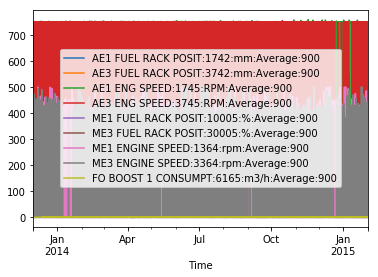

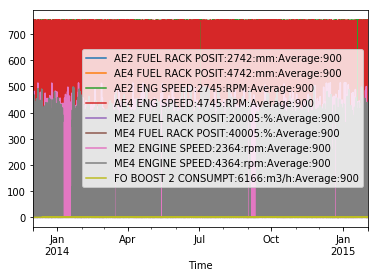

In [4]:
# All that is below zero is set to zero...

for n in list(df_1_3):
    df_1_3[n][(df_1_3[n] < 0)] = 0

for n in list(df_2_4):
    df_2_4[n][(df_2_4[n] < 0)] = 0
    
df_1_3[labels_1_3].plot()
df_2_4[labels_2_4].plot()

# Volume flow meters and mass flow meters, calibration

The volume flow meters, which are installed for each engine side needs to be calibrated or trained, against the
mass flow meters. The mass flow meters are only updated once each day, and therefore we need to create a new
training set which has the sum of each days FO-flow. As we do know the volume flow meters each 15 minute, but the mass flow meters are only measured once each day, we need to crate a calibration between these two values. 

First we'll make a new column with the sum of the volume flow meters (each day) divided with the mass flow meters. This gives us an indication of the amount that differs each day. 

The fuel oil can change in properties, both density and lower heating value depending on how the supplier and last bunkered date. This is information we do not have, so we have to see if we can find other indicators for this. This value should change depending on the fuel properties, and we'll train a model for this using what indicators we have available such as pressure and temperature of the fuel.

In [5]:

fo_features_1_3 = ['AE1 FO INLET PRESS:1603:Bar:Average:900',
                   'AE1 FO INLET TEMP:1605:  C:Average:900',
                   'AE3 FO INLET PRESS:3603:Bar:Average:900',
                   'AE3 FO INLET TEMP:3605:  C:Average:900',
                   'ME1 FO INLET PRESS:1301:bar:Average:900',
                   'ME1 FO INLET TEMP:1302:C:Average:900',
                   'ME3 FO INLET PRESS:3301:bar:Average:900',
                   'ME3 FO INLET TEMP:3302:C:Average:900',
                   'FO TEMP AFTER ME1/3|:6137:C:Average:900'
                  ]

fo_features_2_4 = ['AE2 FO INLET PRESS:2603:Bar:Average:900',
                   'AE2 FO INLET TEMP:2605:  C:Average:900',
                   'AE4 FO INLET PRESS:4603:Bar:Average:900',
                   'AE4 FO INLET TEMP:4605:  C:Average:900',
                   'ME2 FO INLET PRESS:2301:bar:Average:900',
                   'ME2 FO INLET TEMP:2302:C:Average:900',
                   'ME4 FO INLET PRESS:4301:bar:Average:900',
                   'ME4 FO INLET TEMP:4302:C:Average:900',
                   'FO TEMP AFTER ME2/4|:6138:C:Average:900'
                  ]

fuel_oil = df[fo_features_1_3 + fo_features_2_4].dropna()

for n in list(fuel_oil):
    fuel_oil[n][(fuel_oil[n] < 0)] = 0
    


In [6]:
print(fuel_oil.max())
print(fuel_oil.min())

AE1 FO INLET PRESS:1603:Bar:Average:900     11.726667
AE1 FO INLET TEMP:1605:  C:Average:900     110.800000
AE3 FO INLET PRESS:3603:Bar:Average:900     10.946667
AE3 FO INLET TEMP:3605:  C:Average:900      69.333333
ME1 FO INLET PRESS:1301:bar:Average:900     11.986520
ME1 FO INLET TEMP:1302:C:Average:900       110.981686
ME3 FO INLET PRESS:3301:bar:Average:900      8.723745
ME3 FO INLET TEMP:3302:C:Average:900       111.142859
FO TEMP AFTER ME1/3|:6137:C:Average:900    108.673994
AE2 FO INLET PRESS:2603:Bar:Average:900      8.253333
AE2 FO INLET TEMP:2605:  C:Average:900     107.133333
AE4 FO INLET PRESS:4603:Bar:Average:900      9.580000
AE4 FO INLET TEMP:4605:  C:Average:900     148.200000
ME2 FO INLET PRESS:2301:bar:Average:900      9.472365
ME2 FO INLET TEMP:2302:C:Average:900       112.556778
ME4 FO INLET PRESS:4301:bar:Average:900      9.688824
ME4 FO INLET TEMP:4302:C:Average:900       113.172162
FO TEMP AFTER ME2/4|:6138:C:Average:900    104.410257
dtype: float64
AE1 FO INLET 

## Create new column for training factor of mass flow meters and volume flow.

In [7]:

# The FO_1_3 is the mass flow meters, in tonnes for each day.

fo_total = pd.DataFrame(df[['FO_day_engine_1_3','FO_day_engine_2_4']].dropna())

# this gives the total in tonnes for each day.

# We do not have the full time extent for the dataset, so we have to filter out.

date_begin = '2014-02-01'
date_end = '2014-12-16'

# The dataset is not complete overlapping in time with data from both the mass-flow meters and the
# the rest of the data. So we have to manually filter out the time interval which we are interested in.



In [8]:

# This gives the val in m3

fo_total['vol_flow_1_3'] = df['FO BOOST 1 CONSUMPT:6165:m3/h:Average:900'].dropna().resample('1D').sum()*15/60 
fo_total['vol_flow_2_4'] = df['FO BOOST 2 CONSUMPT:6166:m3/h:Average:900'].dropna().resample('1D').sum()*15/60

fo_total['density_1_3'] = fo_total['FO_day_engine_1_3'] / fo_total['vol_flow_1_3']
fo_total['density_2_4'] = fo_total['FO_day_engine_2_4'] / fo_total['vol_flow_2_4']

fo_total = fo_total.dropna()

## Analysis of the density data

It seems that the mass flow meters and the volume flow meters are pretty consistent, but not really that accurate. It is also some data that are way off the chart, especially around December 2014 which could be explained with that they changed to MDO for a period before the sulphur directive came in place. There is also some spikes in the data which either can be explained by the reading if the mass flow meters (which are done manually by the crew at nighttime) might not be at the exact time each day.

As they do bunkering each week it might be a good time to filter the data after those occurancies, also to filter out all outliers.

       density_1_3  density_2_4
count   319.000000   319.000000
mean      0.992145     0.994098
std       0.009963     0.032289
min       0.946711     0.649660
25%       0.987809     0.989044
50%       0.992116     0.994568
75%       0.996516     0.999505
max       1.034909     1.370472


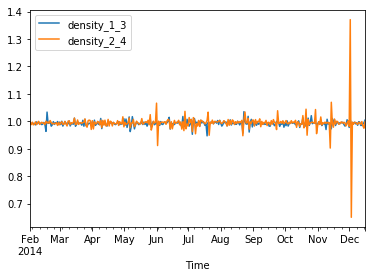

In [9]:
print(fo_total[['density_1_3','density_2_4']].describe())
fo_total[['density_1_3','density_2_4']].plot()

In [10]:
# Filter out high and low quantile, replace with NaN

quantile = 0.1

fo_total['density_1_3'][(fo_total['density_1_3'] > fo_total['density_1_3'].quantile(1-quantile))] = np.nan
fo_total['density_1_3'][(fo_total['density_1_3'] < fo_total['density_1_3'].quantile(quantile))] = np.nan

fo_total['density_2_4'][(fo_total['density_2_4'] > fo_total['density_1_3'].quantile(1-quantile))] = np.nan
fo_total['density_2_4'][(fo_total['density_2_4'] < fo_total['density_1_3'].quantile(quantile))] = np.nan


## Interpolate and fill the outliers, linear interpolation...

In [11]:
fo_total['density_1_3'] = fo_total['density_1_3'].interpolate()
fo_total['density_2_4'] = fo_total['density_2_4'].interpolate()

## Plot new data

The outliers are gone..

       density_1_3  density_2_4
count   319.000000   319.000000
mean      0.991980     0.993024
std       0.004608     0.003379
min       0.981929     0.985083
25%       0.988890     0.990463
50%       0.991744     0.993380
75%       0.995095     0.995749
max       1.003448     0.998875


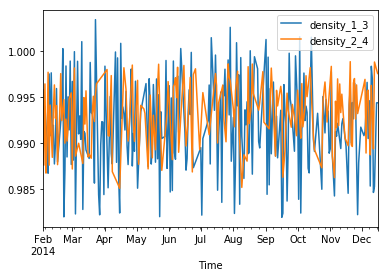

In [12]:
print(fo_total[['density_1_3','density_2_4']].describe())
fo_total[['density_1_3','density_2_4']].plot()

In [13]:
fuel_oil['density_1_3'] = fo_total['density_1_3'].resample('15min').pad()
fuel_oil['density_2_4'] = fo_total['density_2_4'].resample('15min').pad()

## Training model

Now we have a DataFrame with FO features and a prediction value. This should in theory be used as predicting
the mass flow from the volume flow meter. Let's see how it works...

Divide into numpy arrays

In [14]:
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor

df = fuel_oil.dropna() # Drop all NaN so all arrays are alike in size, and also not any NaN ..

X_13 = np.array(df[fo_features_1_3].dropna())
y_13 = np.array(df['density_1_3'])

gen = 10
cores=-1 # use all of them

X_train_13, X_test_13, y_train_13, y_test_13 = train_test_split(X_13, y_13, train_size=0.75, test_size=0.25)
tpot = TPOTRegressor(generations=gen, population_size=50, verbosity=2, n_jobs=cores)
tpot.fit(X_train_13, y_train_13)
print(tpot.score(X_test_13,y_test_13))


/home/fredde/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Optimization Progress:  18%|█▊        | 100/550 [00:37<26:04,  3.48s/pipeline]

Generation 1 - Current best internal CV score: 5.335322860823024e-06


Optimization Progress:  27%|██▋       | 150/550 [01:17<29:55,  4.49s/pipeline]

Generation 2 - Current best internal CV score: 5.088402163475137e-06


Optimization Progress:  36%|███▋      | 200/550 [02:28<23:34,  4.04s/pipeline]

Generation 3 - Current best internal CV score: 5.088402163475137e-06


Optimization Progress:  45%|████▌     | 250/550 [03:18<48:49,  9.77s/pipeline]  

Generation 4 - Current best internal CV score: 5.088402163475137e-06


Optimization Progress:  55%|█████▍    | 300/550 [04:18<28:06,  6.75s/pipeline]

Generation 5 - Current best internal CV score: 5.088402163475137e-06


Optimization Progress:  64%|██████▎   | 350/550 [05:43<28:46,  8.63s/pipeline]

Generation 6 - Current best internal CV score: 4.955779863050546e-06


Optimization Progress:  73%|███████▎  | 400/550 [06:44<25:34, 10.23s/pipeline]

Generation 7 - Current best internal CV score: 4.955779863050546e-06


Optimization Progress:  82%|████████▏ | 450/550 [10:39<24:43, 14.83s/pipeline]

Generation 8 - Current best internal CV score: 4.898374949575888e-06


Optimization Progress:  91%|█████████ | 500/550 [12:18<11:01, 13.24s/pipeline]

Generation 9 - Current best internal CV score: 4.80998543787287e-06


Generation 10 - Current best internal CV score: 4.736807123418824e-06

Best pipeline: ExtraTreesRegressor(ExtraTreesRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.7, min_samples_leaf=2, min_samples_split=4, n_estimators=100), bootstrap=True, max_features=0.8, min_samples_leaf=2, min_samples_split=14, n_estimators=100)
4.67216742533e-06


In [29]:
from sklearn.externals import joblib
import pickle

tpot.export('trained_models/fo_volume_mass_1_3.py')
#joblib.dump(tpot,'trained_models/fo_volume_mass_1_3.pk1')

pickle.dump(tpot, open('trained_models/fo_volume_mass_1_3.pk1', 'wb' ))

PicklingError: Can't pickle <class 'tpot.operator_utils.ExtraTreesRegressor__bootstrap'>: attribute lookup ExtraTreesRegressor__bootstrap on tpot.operator_utils failed

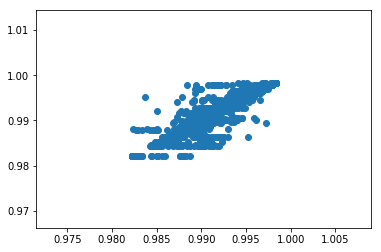

In [20]:
plt.scatter(tpot.predict(X_13),y_13)

## Conclusion about the model...

It seems that there is quite hard to do anything about the mass flow and volume flow meters with the data that we have available. The difference is very small anyway, after less than 0.5%

Below is a simple linear regression.


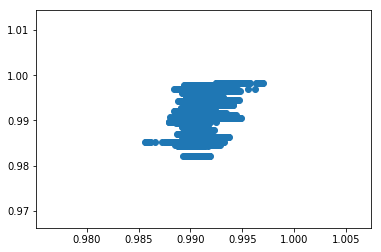

In [41]:
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X_train_13,y_train_13)
linear_model.score(X_test_13,y_test_13)
plt.scatter(linear_model.predict(X_13),y_13)

In [45]:

X_13 = np.array(df_1_3.drop(labels='FO BOOST 1 CONSUMPT:6165:m3/h:Average:900',axis=1))
y_13 = np.array(df_1_3['FO BOOST 1 CONSUMPT:6165:m3/h:Average:900'])


In [46]:
X_13.shape

(41029, 8)

In [47]:
y_13.shape

(41029,)